# Generate Simple Flow-Centric Traffic

In this example, we will use `TrafPy` to generate a very simple flow-centric traffic trace with uniform node distributions and with constant flow size and inter-arrival time. This is useful for quickly generating quick and simple traffic traces to test your systems are running as you expect them to.

We will then save these traffic traces as .pickle files, which can then be imported into any simulation, emulation, or experimentation environment/test bed independently of `TrafPy`. We will also organise the demonstrated traffic into time slots and generate an sqlite data base which we can save to our disk and access during a simulation, thereby enabling us to scale to very large simulation sizes.

To do this, we will need to use the `trafpy.generator` module.

In [1]:
import trafpy.generator as tpg

## 1. Define the Network

Consider that you have a network with $n_{n}=16$ end points/machines/leaf nodes, and that you've defined your network externally to TrafPy, but you would like to use TrafPy to generate the University, Private Enterprise, Commercial Cloud, and Social Media Cloud traffic traces for your network. Regardless of your network's topology, we can use the `trafpy.generator.gen_arbitrary_network()` function to initialise an arbitrary representation of your network which TrafPy can recognise and create traffic data for.

Start by setting how many end points are in your network:

In [2]:
num_eps = 16

### Network Bandwidth Capacity

Each link in your network will have (1) some bandwidth capacity per link channel (the maximum rate of information transfer per unit time on each channel) $C_{c}$, and (2) some number of channels per link $n_{c}$. `TrafPy` will assume that your links are *bidirectional*, meaning traffic can simultaneously be outbound and inbound from/to a given end point, therefore each link channel's bandwidth is split between the end points' transceiver (source) and receiver (destination) port. Consider that your network has link channel capacity $C_{c}=1250$ and $n_{c}=1$ channels:

In [3]:
ep_capacity = 1250

You can now initialise your network in a format recognised by `TrafPy` using the `trafpy.generator.gen_arbitrary_network()` function:

In [4]:
net = tpg.gen_arbitrary_network(num_eps=num_eps, ep_capacity=ep_capacity)

The *total network capacity* $C_{t}$ is the maximum amount of information which can be transmitted through the entire network per unit time. If 2 end points are connected, the most amount of information they can transfer along a single channel per unit time is the end point bandwidth capacity per channel $C_{c}$ (*not* $2 \cdot C_{c}$), therefore the network's total capacity $C_{t}$ can be evaluated as:

\begin{equation}
    C_{t} = \frac{n_{n} \cdot C_{c} \cdot n_{c}}{2}
\end{equation}

All `TrafPy` networks and graphs are `NetworkX` graphs (see [here](https://networkx.org/documentation/stable/tutorial.html) for details) which can be treated as Python dictionaries. All `TrafPy` networks have the following 'global' graph keys:

In [5]:
print(net.graph.keys())
print(net.graph['topology_type'])

dict_keys(['endpoints', 'endpoint_label', 'num_channels_per_link', 'ep_link_capacity', 'ep_link_port_capacity', 'max_nw_capacity', 'curr_nw_capacity_used', 'num_active_connections', 'total_connections_blocked', 'node_labels', 'topology_type', 'channel_names', 'rack_to_ep_dict', 'ep_to_rack_dict'])
arbitrary_endpoints_16_chancap_1250_channels_1


Notice that TrafPy has automatically evaluated the maximum capacity of your network:

In [6]:
print(net.graph['max_nw_capacity'])
print(net.graph['topology_type'])

10000.0
arbitrary_endpoints_16_chancap_1250_channels_1


Notice also that all references to capacity have been unitless. $C_{c}=1250$ could refer to e.g. 1250 B/s, 1250 $\mu$B/ms, 1250 Gbps, and so on. This is intentional, and allows you to plug in whatever values you find convenient. Just ensure the information and time units you use are consistent.

## 2. Define the Load Configuration

The network load refers to the overall amount of traffic received by the network. This is commonly referred to as a load rate (information units arriving per unit time) or as a load fraction (the fraction of the total network capacity being requested for a given duration). `TrafPy` typically uses the load fraction definition for load, therefore loads can be varied between 0 and 1.

A key feature of `TrafPy` is that you can generate any load for your custom network. To do this, you should provide `TrafPy` with a `network_load_config` dictionary which tells `TrafPy` (1) the end point capacity of your network, (2) the maximum capacity of your network, and (3) the overall load fraction you would like `TrafPy` to generate for your network. Consider that you would like `TrafPy` to generate a 0.1 load traffic trace for your network (i.e. around 10% of your total network capacity will be requested per unit time):

In [7]:
network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                       'ep_link_capacity': net.graph['ep_link_capacity'],
                       'target_load_fraction': 0.1}

## 3. Define the Flow Distributions

We will generate 3 very simple flow distributions: A uniform node distribution, a flow size distributions where all flow sizes are 1.0 information units, and an inter-arrival time distribution where all flow inter-arrival times are 1.0 time units.

Note that the inter-arrival times will automatically be adjusted by `TrafPy` to meet your `network_load_config` requirements.

In [8]:
dists = {}
dists['node_dist'] = tpg.gen_uniform_node_dist(eps=net.graph['endpoints'])
dists['interarrival_time_dist'] = {1.0: 1.0}
dists['flow_size_dist'] = {1.0: 1.0}

## 4. (Optional) Define Additional Trace Parameters

`TrafPy` generates traffic trace data for your network using the `trafpy.generator.create_demand_data()` function. This function has some useful additional parameters you can define to further customise the trace generated for your network (see documentation for details).

An important parameter in `TrafPy` traffic generation is the `jensen_shannon_distance_threshold`. Since `TrafPy` traffic data are generated by sampling from some pre-defined distributions, how similar the sampled data are to the original distributions will depend on the number of demands generated/sampled by the law of large numbers. `TrafPy` lets you set the `jensen_shannon_distance_threshold`, which must be between 0 and 1. A lower value will result in more demands being generated and therefore a data set more similar to the original distributions you are sampling from, whereas a higher value will be less reliably similar but will result in fewer demands (which can reduce the memory and time size of your tests).

Other useful additional parameters include `min_last_demand_arrival_time`, `min_num_demands`, and `max_num_demands`. See documentation for details.

Here, we will set `jensen_shannon_distance_threshold=0.9` (a high value so that we don't generate many demands and therefore save time).

In [9]:
jsd_threshold = 0.9

## 5. Generate the Traffic Traces

With our network and flow distributions, we are now ready to generate some traffic for our custom network using the `trafpy.generator.create_demand_data()` function. We will save our traffic into separate .pickle files. These files can then be imported into your own simulation, emulation, and/or experimentation test beds to test your own systems under this traffic.

In [10]:
from pathlib import Path
import gzip
import pickle
import time

path_to_data = 'data/generate_simple_flow_traffic/'
Path(path_to_data).mkdir(exist_ok=True, parents=True)
print('Generating simple traffic demands for {} network'.format(net.graph['topology_type']))
time.sleep(1)

# generate traffic demands
demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                     node_dist=dists['node_dist'],
                                     flow_size_dist=dists['flow_size_dist'],
                                     interarrival_time_dist=dists['interarrival_time_dist'],
                                     network_load_config=network_load_config,
                                     jensen_shannon_distance_threshold=jsd_threshold)

# save demands as pickle file
filename = path_to_data+'simple_demand_data.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(demand_data, f)

Generating simple traffic demands for arbitrary_endpoints_16_chancap_1250_channels_1 network


Packed 6000 flows in 0.6732933521270752 s.


`demand_data` is a dictionary storing the following information for each flow (where the values are a list of values corresponding to the values assigned to each flow):

In [11]:
print(demand_data.keys())

dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])


## 6. (Optional) Analyse the Generated Traffic

At this point, you could do your own analysis of the traffic you've generated by loading the saved data into your own scripts. However, `TrafPy` provides some useful tools for this.

We can encode our saved `demand_data` files as `trafpy.generator.Demand()` objects, and then use the `trafpy.generator.DemandsAnalyser` and `trafpy.generator.DemandPlotter` objects to analyse them:

In [12]:
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter

First collect the demand objects from each demand_data file:

In [13]:
# collect demand objects
demands = {}
with gzip.open(path_to_data+'simple_demand_data.pickle', 'rb') as f:
    demand_data = pickle.load(f)
demands['simple'] = Demand(demand_data, net.graph['endpoints'], name='simple')

Then use `trafpy.generator.DemandsAnalyser()` to print a summary table of all the demand data sets you generated:

In [14]:
# print summary table
analyser = DemandsAnalyser(*list(demands.values()), jobcentric=False)
analyser.compute_metrics(print_summary=True)

Name  Flows  1st  Last  Duration    Info    Load  Smallest  Largest
0  simple   6000  0.0   6.0       6.0  6000.0  1000.0       1.0      1.0

Finally, visualise your data:

simple
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


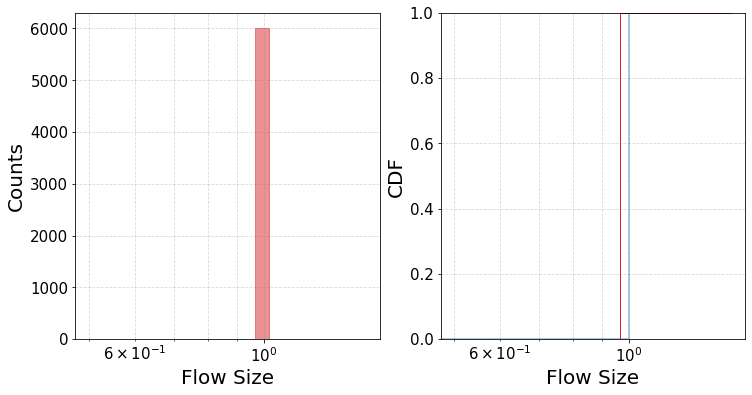

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.0010001666944488008, 0.0010001666944492449), mean=0.0010001666944490274, variance=3.3103629850412677e-32, skewness=-0.07247390513455162, kurtosis=-1.5165869988500134)


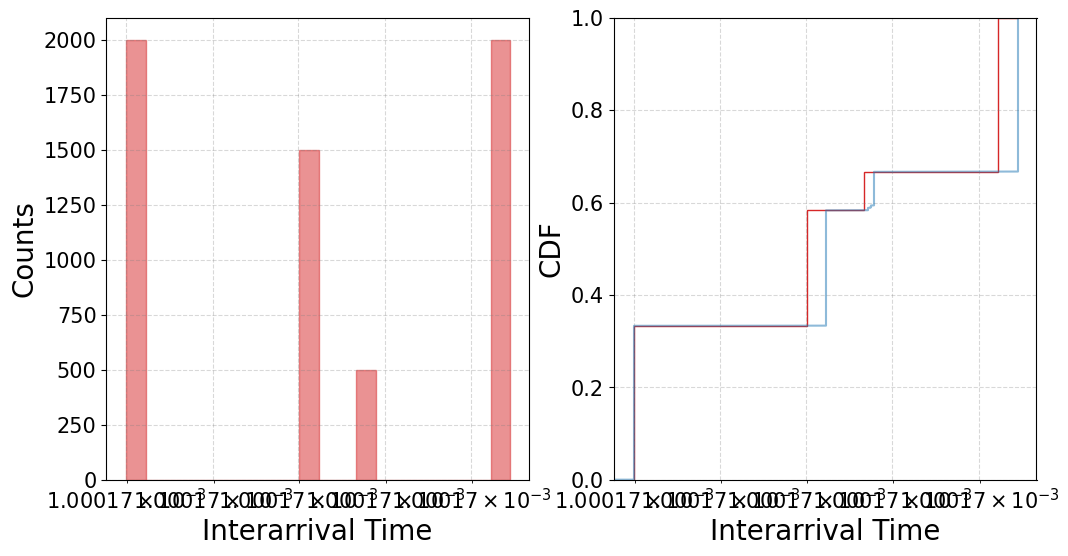

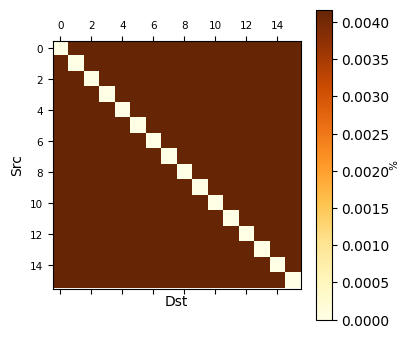

Src-dst edge weights in chord diagram are all the same, leading to 0 rescaled values. Decrease chord_edge_display_threshold to ensure a range of edge values are included in the chord diagram.


<Figure size 640x480 with 0 Axes>

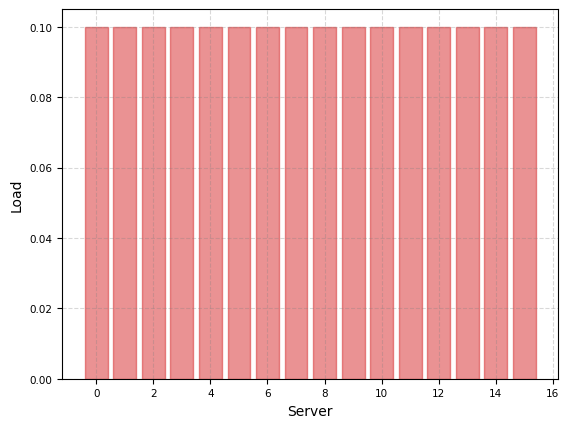

<Figure size 640x480 with 0 Axes>

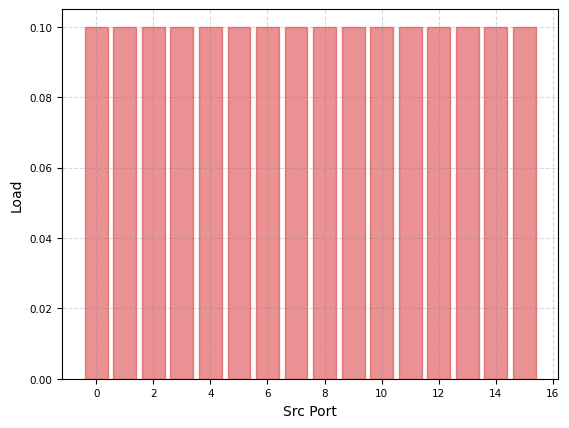

<Figure size 640x480 with 0 Axes>

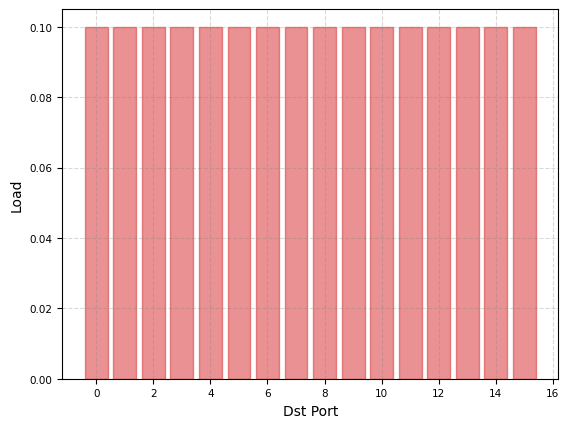

In [15]:
# visualise distributions
for name, demand in demands.items():
    print(name)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, figsize=(12,6))
    plotter.plot_interarrival_time_dist(logscale=True, figsize=(12,6))
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.005)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'],
                                 plot_extras=False)

# 7. (Optional) Generate a slots dict data base

Many network experiments are based on time slots. I.e. during a time slot of e.g. 10 time units, some number of flows arrive. The `trafpy.generator.Demand()` class has a useful `get_slots_dict()` method to automatically organise your generated traffic demands into time slots given the `slot_size` you want to use:

In [16]:
slots_dict = demand.get_slots_dict(slot_size=0.5)

The `slots_dict` dictionary contains indices 0-n for `n` slots, as well as some other useful information:

In [17]:
print(slots_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'slot_keys', 'slot_size', 'time_first_demand_arrived', 'time_last_demand_arrived', 'job_centric', 'num_control_deps', 'num_data_deps', 'num_flows', 'num_demands'])


E.g. To access the flows which arrived in the first time slot (with upper bound and lower bound times on the time slot also given since this is often useful):

In [18]:
print(slots_dict[0])

{'lb_time': 0.0, 'ub_time': 0.5, 'new_event_dicts': [{'flow_id': 'flow_5853', 'unique_id': 'flow_5853', 'size': 1.0, 'src': '0', 'dst': '12', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived': 0.0, 'time_completed': None, 'k_shortest_paths': None}, {'flow_id': 'flow_49', 'unique_id': 'flow_49', 'size': 1.0, 'src': '12', 'dst': '5', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived': 0.00100016669

Next time slot flows:

In [19]:
print(slots_dict[1])

{'lb_time': 0.5, 'ub_time': 1.0, 'new_event_dicts': [{'flow_id': 'flow_3782', 'unique_id': 'flow_3782', 'size': 1.0, 'src': '15', 'dst': '14', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived': 0.5000833472245388, 'time_completed': None, 'k_shortest_paths': None}, {'flow_id': 'flow_5122', 'unique_id': 'flow_5122', 'size': 1.0, 'src': '6', 'dst': '1', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arri

And so on.

For large simulations, it is recommended to save the `slots_dict` as a database on your disk which you can query during your simulation. The `SqliteDict` library is particularly useful for this since it lets you save a database in .sqlite file format whilst still allowing you to query the database as if it were a normal Python dictionary. See [here](https://pypi.org/project/sqlitedict/) for more details.

To save your `slots_dict` as a .sqlite database with `SqliteDict`, run:

In [20]:
from sqlitedict import SqliteDict
import json

with SqliteDict(path_to_data+'simple_demand_data_slots_dict.sqlite') as _slots_dict:
    for key, val in slots_dict.items():
        if type(key) is not str:
            _slots_dict[json.dumps(key)] = val
        else:
            _slots_dict[key] = val
    _slots_dict.commit()
    _slots_dict.close()